# Experiments with hidden states

Question, is there a better representation of concepts in hidden states?

Setup: we use DPO setup, with a chosen and rejected string. We then generate a set of hidden states, and compare the hidden states of the chosen and rejected string.

Goal: better generalisation of desired behavuour by changing the internal representation of policy rather than directly changing the policy

  - Hypothesis: rejected and chosen hidden states will - on mean - be best representated as rotations from each other
  - alternate: either mean mass diff (linear) or no repr will be better
  - metric: manual generation getting output while maintaining coherency, prediction other sets of hs

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_PROJECT"] = "repo-dpo" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["WANDB_DISABLED"] = "true"

In [3]:
import numpy as np

from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import DPOTrainer
from trl import DPOConfig, DPOTrainer

import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union
from jaxtyping import Float
from einops import rearrange, reduce

from pathlib import Path

from reprpo.helpers.adapters import set_adapter
from matplotlib import pyplot as plt
from reprpo import silence
from reprpo.gen import generation_test

from reprpo.trainer import mean_with_attention, symlog, mult_with_attention

from tqdm.auto import tqdm
from reprpo.trainer import collect_hs, ReprPOConfig, ReprPOTrainer, normalize_output, normalize_per
from reprpo.helpers.shypothesis import shypothesis
from datasets import load_dataset

## Load model

In [4]:
from reprpo.models.load import load_model, print_trainable_parameters
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model
model_name = "NousResearch/Meta-Llama-3-8B-Instruct"
model_name = "microsoft/Phi-3-mini-4k-instruct"

use_gradient_checkpointing = False
model, tokenizer = load_model(model_name, bnb=True) 
# from trl.trainer.utils import peft_module_casting_to_

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
peft_config = LoraConfig(
    target_modules=[
    #     # "qkv_proj", "gate_up_proj", # in
        "down_proj",  "o_proj", # out
    ]
)
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model
from trl.trainer.utils import peft_module_casting_to_bf16
peft_module_casting_to_bf16(model)
adapter_name='ReprPO'
model = prepare_model_for_kbit_training(model, {'use_gradient_checkpointing': use_gradient_checkpointing})
model = get_peft_model(model, peft_config, adapter_name=adapter_name)

## Load adapter

In [6]:
# dpo_adapter_f = './output-dir/dpo/DPO'
# model.load_adapter(dpo_adapter_f, 'DPO')

In [7]:
# # QC model and adapter is coherent
# generation_test(model, tokenizer, max_new_tokens=24, system='no yapping', adapter_names=[None, 'DPO'])

## Load DPO dataset

In [8]:
num_samples = 160

In [9]:
def sample(dataset, N):
    return (dataset
            .shuffle(42)
            .select(range(
            min(len(dataset),
                N)))
    )

dataset = load_dataset('Atsunori/HelpSteer2-DPO')
dataset['train'] = sample(dataset['train'], num_samples)
dataset['validation'] = sample(dataset['validation'], num_samples)
dataset2 = dataset.rename_column('chosen_response', 'chosen').rename_column('rejected_response', 'rejected')
dataset2

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 160
    })
    validation: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 160
    })
})

In [10]:
def foo(row):
    row['prompt']=row['prompt']+"."
    return row
dataset2 = dataset2.map(foo)

In [11]:
a=np.array([len(l) for l in dataset2['train']['chosen']])
b=np.array([len(l) for l in dataset2['train']['rejected']])
a.mean(), b.mean()

## Collect HS in DPO way

In [12]:
training_args = ReprPOConfig('./output-dir/scratch',
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    bf16=True,
    # tf32=True,
    max_prompt_length=64,
    max_length=128,
    collection_layers=[20,],
    remove_unused_columns=False,

    # optim = "adamw_8bit",
    lr_scheduler_type="constant",
    learning_rate=1e-3,
    gradient_checkpointing=use_gradient_checkpointing,
    # adapter_name="DPO",
 )
reprpo_trainer = ReprPOTrainer(
    model=model,
    ref_model=None,
    args=training_args,
    beta=training_args.beta,
    train_dataset=dataset2["train"],
    eval_dataset=dataset2["validation"],
    tokenizer=tokenizer,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [13]:
# QC get dpo catch
dl = reprpo_trainer.get_train_dataloader()
batch = next(iter(dl))
batch['chosen_input_ids'].shape

torch.Size([2, 128])

In [15]:
from baukit.nethook import recursive_copy, set_requires_grad
from torch import Tensor

In [16]:
# clone this linear, using a clone of the weights and bias
m = model.lm_head
m2 = nn.Linear(m.in_features, m.out_features)
m2.weight = nn.Parameter(m.weight.clone().float())
if m.bias is not None:
    m2.bias = nn.Parameter(m.bias.clone().float())
m2 = m2.cpu()

lm_head = m2
m = None


In [17]:
from reprpo.helpers.svd_decomposer import DualSVDDecomposer, SVDDecomposer


In [18]:
# decomposer = OptimizedSVDDecomposer(lm_head)  # Adjust epsilon as needed
decomposer = DualSVDDecomposer(model.get_input_embeddings().weight.clone().float().cpu(), model.lm_head.weight.clone().float().cpu())

In [19]:
# get batch of hidden states
from reprpo.helpers.torch import clear_mem
from trl.trainer.utils import pad_to_length
from torch import Tensor
from jaxtyping import Float



# @torch.cuda.amp.autocast()
def get_hs(trainer, model, batch, collect_gradient=False):
    model.zero_grad()
    model.train()

    if collect_gradient:
        raise NotImplementedError('Not implemented yet, gradient is None?')
        def make_inputs_require_grad(module, input, output):
            output.requires_grad_(True)
        model.get_input_embeddings().register_forward_hook(make_inputs_require_grad)

    
    (
        chosen_logps,
        rejected_logps,
        chosen_logits,
        rejected_logits,
        _,
        chosen_hs,
        rejected_hs,
        chosen_attn_mask,
        rejected_attn_mask
    ) = trainer.concatenated_forward(trainer.model, batch)

    r = dict(chosen_hs=chosen_hs, rejected_hs=rejected_hs, chosen_logps=chosen_logps, rejected_logps=rejected_logps, chosen_attn_mask=chosen_attn_mask, rejected_attn_mask=rejected_attn_mask,
            chosen_logits=chosen_logits,
            rejected_logits=rejected_logits,
             )


    if collect_gradient:
        chosen_hs.retain_grad()
        rejected_hs.retain_grad()
        loss = (chosen_logps - rejected_logps).mean()
        trainer.accelerator.backward(loss)
        print('chosen_hs.grad', chosen_hs.grad)
        assert chosen_hs.grad is not None, 'FIXME'
        r['chosen_hs_grad'] = chosen_hs.grad
        r['rejected_hs_grad'] = rejected_hs.grad



    # get unembected hs
    r['chosen_unemb'] = model.lm_head(chosen_hs)
    r['rejected_unemb'] = model.lm_head(rejected_hs)

    def get_layer_logps(trainer, hidden_states: Float[Tensor, 'b l t h'], labels: Float[Tensor, 'b t'], log_softmax=True):
        # pad to length
        hidden_states = pad_to_length(hidden_states, trainer.max_length, pad_value=0)
        labels = pad_to_length(labels, trainer.max_length, pad_value=trainer.label_pad_token_id)

        # gather for each layer
        logps = []
        for layer in range(hidden_states.shape[1]):
            all_logps, size_completion = trainer.get_batch_logps(
                hidden_states[:, layer],
                labels,
                label_pad_token_id=trainer.label_pad_token_id,
                log_softmax=log_softmax
                )
            all_logps = all_logps / size_completion
            logps.append(all_logps)
        all_logps = torch.stack(logps, dim=1)
        return all_logps
    
    # get fake logp from unemb_hs
    r['chosen_gthr_logps_unemb'] = get_layer_logps(trainer, r['chosen_unemb'], batch["chosen_labels"])
    r['rejection_gthr_logps_unemb'] = get_layer_logps(trainer, r['rejected_unemb'], batch["rejected_labels"])

    r['chosen_gthr_unemb'] = get_layer_logps(trainer, r['chosen_unemb'], batch["chosen_labels"], log_softmax=False)
    r['rejection_gthr_unemb'] = get_layer_logps(trainer, r['rejected_unemb'], batch["rejected_labels"], log_softmax=False)
    
    # we reuse the function, adding a fake layer dim, and squeezing it out
    r['chosen_gthr_logits'] = get_layer_logps(trainer, chosen_logits[:, None], batch["chosen_labels"], log_softmax=False).squeeze(1)
    r['rejected_gthr_logits'] = get_layer_logps(trainer, rejected_logits[:, None], batch["rejected_labels"], log_softmax=False).squeeze(1)

    # unproject for chosen_hs and rejected_hs
    for k in list(r.keys()):
        if k.endswith('_hs'):
            hs_ov = decomposer(r[k])
            hs_r = r[k] - hs_ov
            r[k+'_r'] = hs_r
            r[k+'_h'] = hs_ov

    r = {k: recursive_copy(v, clone=True, detach=True).detach().cpu() for k, v in r.items()}
    loss = chosen_hs = rejected_hs = chosen_logps = rejected_logps = chosen_logits = rejected_logits = None
    clear_mem(trainer)
    
    return r

In [20]:

n = 0 

dl = reprpo_trainer.get_eval_dataloader()
data = []
for batch in tqdm(dl):
    with reprpo_trainer.null_ref_context():
        r = get_hs(reprpo_trainer, reprpo_trainer.model, batch)
        data.append(r)
        n += r['chosen_hs'].shape[0]
        if n > 64:
            break

# concat
data = {k: torch.cat([d[k] for d in data], dim=0) for k in data[0].keys()}
data['chosen_hs'].shape

  0%|          | 0/80 [00:00<?, ?it/s]

The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


torch.Size([66, 1, 128, 3072])

In [21]:
clear_mem(reprpo_trainer)


In [22]:
data.keys()

dict_keys(['chosen_hs', 'rejected_hs', 'chosen_logps', 'rejected_logps', 'chosen_attn_mask', 'rejected_attn_mask', 'chosen_logits', 'rejected_logits', 'chosen_unemb', 'rejected_unemb', 'chosen_gthr_logps_unemb', 'rejection_gthr_logps_unemb', 'chosen_gthr_unemb', 'rejection_gthr_unemb', 'chosen_gthr_logits', 'rejected_gthr_logits', 'chosen_hs_r', 'chosen_hs_h', 'rejected_hs_r', 'rejected_hs_h'])

In [23]:
# TODO try getting residual hidden states are removing what might be used by lm_head, e.g. disentangling the part not projected
# model = None
clear_mem(reprpo_trainer)
# reprpo_trainer = None
clear_mem()

In [24]:
# data['chosen_hs']-data['rejected_hs']

In [25]:
# out_dict = dict(
#     data=data,
#     WO=lm_head.weight.clone().detach().cpu(),
#     WE=model.get_input_embeddings().weight.clone().detach().cpu(),
# )
# torch.save(out_dict, '../test/data/dual_svd_decomposer.pt')

### Disentangling hiddenstates into inner and head components

Hypothesis: hidden states contain both "output-directed" information (what will be unembedded to logits) and "internal processing" information. This seems possible because 1) we can unembed the hidden states 2) the hidden states remain fairly constant throughout the layer being additivly transformed by residual connections.

Test: do we get a better correlation with concepts. And does it generalise?

## Get samples

In [26]:
data.keys()

dict_keys(['chosen_hs', 'rejected_hs', 'chosen_logps', 'rejected_logps', 'chosen_attn_mask', 'rejected_attn_mask', 'chosen_logits', 'rejected_logits', 'chosen_unemb', 'rejected_unemb', 'chosen_gthr_logps_unemb', 'rejection_gthr_logps_unemb', 'chosen_gthr_unemb', 'rejection_gthr_unemb', 'chosen_gthr_logits', 'rejected_gthr_logits', 'chosen_hs_r', 'chosen_hs_h', 'rejected_hs_r', 'rejected_hs_h'])

In [35]:
dl = reprpo_trainer.get_eval_dataloader()
batch = next(iter(dl))
print('prompt', batch['prompt'][0])
print('-'*80)
print('chosen\n', batch['chosen'][0])
print('-'*80)
print('rejected\n', batch['rejected'][0])

prompt give me some of the literature survey of phishing websites using data mining.
--------------------------------------------------------------------------------
chosen
 Phishing is a type of cyber attack that involves creating fake websites to steal personal information, such as login credentials and credit card numbers. Data mining is a technique used to analyze large amounts of data to identify patterns and trends. It can be used to detect phishing websites by analyzing various features, such as URL, content, and user behavior.

Here are some recent literature surveys on phishing website detection using data mining:

1. "A Survey on Phishing Website Detection Using Data Mining Techniques" by M. Mohana Priya and P. Srividya (International Journal of Trend in Research and Development (IJTRD), Vol. 4, Issue 11, November 2017). This survey paper provides an overview of various data mining techniques used for phishing website detection, including decision trees, Bayesian networks, ar

In [28]:
concatenated_batch = reprpo_trainer.concatenated_inputs(
    batch,
    is_encoder_decoder=reprpo_trainer.is_encoder_decoder,
    is_vision_model=reprpo_trainer.is_vision_model,
    label_pad_token_id=reprpo_trainer.label_pad_token_id,
    padding_value=reprpo_trainer.padding_value,
    device=reprpo_trainer.accelerator.device,
    max_length=reprpo_trainer.max_length
)

b0_tokens = concatenated_batch['concatenated_input_ids'][0]
print(b0_tokens, b0_tokens.shape, reprpo_trainer.max_length)
print(tokenizer.decode(b0_tokens, skip_special_tokens=False))

tensor([    1,  2367,   592,   777,   310,   278, 12845, 18994,   310,  1374,
        14424, 28007,   773,   848,  1375,   292, 29889,  4819, 14424,   338,
          263,  1134,   310,  5094,   495,  5337,   393, 20789,  4969, 25713,
        28007,   304,  1886,   284,  7333,  2472, 29892,  1316,   408,  6464,
        16140,   322, 16200,  5881,  3694, 29889,  3630,  1375,   292,   338,
          263, 11043,  1304,   304, 27599,  2919, 26999,   310,   848,   304,
        12439, 15038,   322,   534,  1975, 29889,   739,   508,   367,  1304,
          304,  6459,  1374, 14424, 28007,   491, 29537,   292,  5164,  5680,
        29892, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000],

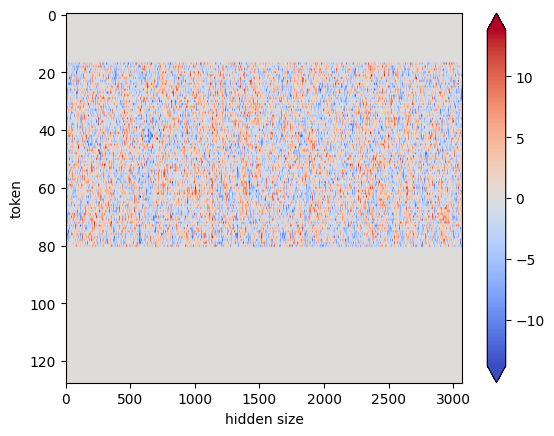

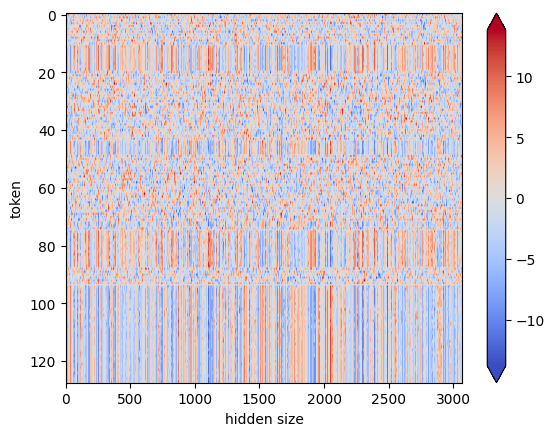

In [29]:
# plot decompose(C-R)
C = data['chosen_hs_r'].float() # we could also consider unembedding them, whith the lm head, this might make them more interpretable, but also a bit large
R = data['rejected_hs_r'].float()

# C = decomposer.decompose(C.cpu())[0]
# R = decomposer.decompose(R.cpu())[0]

def decom(x):
    return x - decomposer(x)

x = decom(C)-decom(R)

# x = decom(C-R)

def imshow(x):
    x = symlog(x)
    v = x.abs().max()
    plt.imshow(x, cmap='coolwarm', aspect='auto', vmin=-v, vmax=v)
    plt.colorbar(extend='both')
    plt.xlabel('hidden size')
    plt.ylabel('token')


imshow(x[0,0])
plt.show()
imshow(x[:, 0].mean(0))

In [36]:
# Oh... I didn't realise by the decomposer can be moved
C = data['chosen_hs_r']
R = data['rejected_hs_r']

a = (C-decomposer(C)) - (R - decomposer(R))
b = (C-R) - decomposer(C-R)

((a-b)/(abs(a)+abs(b))).mean()

tensor(nan)

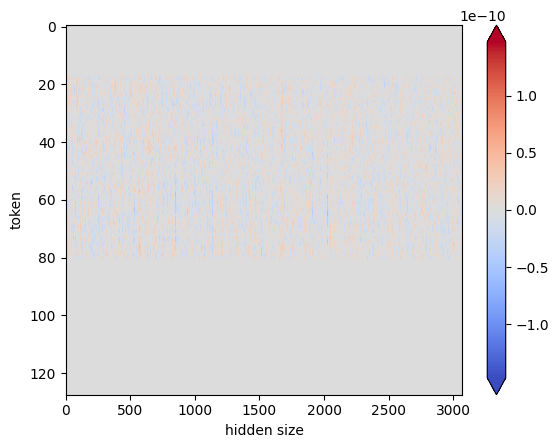

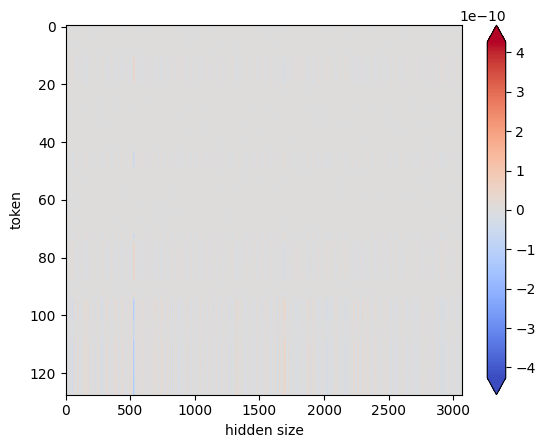

In [31]:

C = data['chosen_hs_r']
R = data['rejected_hs_r']

C = C - decomposer(C)
R = R - decomposer(R)

x = (C-R)

def imshow(x):
    # x = symlog(x)
    v = x.abs().max() / 3
    plt.imshow(x, cmap='coolwarm', aspect='auto', vmin=-v, vmax=v)
    plt.colorbar(extend='both')
    plt.xlabel('hidden size')
    plt.ylabel('token')


imshow(x[0,0])
plt.show()
imshow(x[:, 0].mean(0))

In [51]:
X = C-R
# hs_internal_in = x - decomposer.decomposer_in(x)
X2 = decomposer.decomposer_in.test(C[0, 0]-R[0,0])
# X2-X
# np.testing.assert_allclose(X2, X, rtol=1e-1)

Original: 9.353099544862076e-11
Output: 9.353111340981712e-11
Internal: 1.7113223845824914e-21


In [44]:
# C.shape

In [ ]:
# get some data samples
layer = 0
C = data['chosen_hs_r'].float() # we could also consider unembedding them, whith the lm head, this might make them more interpretable, but also a bit large
R = data['rejected_hs_r'].float()

C /= C.norm(dim=-1, keepdim=True)
R /= R.norm(dim=-1, keepdim=True)

C = C - decomposer(C.cpu())
R = R-decomposer(R.cpu())

CA = data['chosen_attn_mask']
RA = data['rejected_attn_mask']

M = 100
A2 = CA * RA # use both attn masks when comparing?

# choose layer, mean over tokens
C = mult_with_attention(C, A2)[:M, layer]
C = reduce(C, 'b t h -> b h', 'mean')
R = mult_with_attention(R, A2)[:M, layer]
R = reduce(R, 'b t h -> b h', 'mean')

# compare two unrelated sets of samples, that way we have ones that should show the difference and ones that shouldn't show the difference we arel ooking for
n = len(C)//2
C1 = C[:n] # chosen pair 1
R1 = R[:n] # rejected pair 1
C2 = C[n:] # chosen, pair 2
R2 = R[n:] # rejected pair 2


# now we choose what to test correlations with. At first I tried the logprobs but they have been through a softmax which makes them relative and hard to compare to the hidden states
# so instead we are going to try the hidden states values that corresponded to the 

# logratios = data['chosen_logps'] - data['rejected_logps'] # the logp is the log probability (mean per token) of this response, logratios is the log ratio of probs, this should be correlated with the direction we are seeking in the hidden states

# logratios = (data['chosen_gthr_logits'] - data['rejected_gthr_logits'])#.exp()
logratios = data['chosen_gthr_unemb'][:, layer] - data['rejection_gthr_unemb'][:, layer]
logratios = logratios.float()

# we can use this to check the null hypothesis, as the `roll` operation mixes up the batch dimension, so they are unrelated
# logratios_unrelated = logratios.roll(1, 0)

logratios1 = logratios[:n]
logratios2 = logratios[n:]
logratios2.shape

torch.Size([33])

## Hypothesis

### Magnitude/norm is correlated with result?

Is the amplitude of A-B related to the logp?

In [ ]:
# logratios

In [ ]:
# ur using abs corrcoef
def acorr(A, B):
    return (np.corrcoef(A, B, rowvar=True)[0, 1])

def mag_corr(C, R, logratios):
    hs_d = torch.norm(C-R, dim=-1, p=2) # get magnitude of the difference
    corr = acorr(hs_d, logratios)
    # note that after flipping we ruin the order, and they should be uncorrelated except for the middle one if it's odd
    corr_null = acorr(hs_d, logratios.roll(1, 0))
    return corr, corr_null
    

print('does the magnitude of the hs_unemb correlate with the prob ratio (across batches)? if so it\'s a good repr')

print("should be significantly bigger")
corr, corr_null = mag_corr(C1, R1, logratios1)
shypothesis("corr>corr_null", variables=dict(corr=corr, corr_null=corr_null))

print("should pass")
corr, corr_null = mag_corr(C2, R2, logratios2)
shypothesis("corr>corr_null", variables=dict(corr=corr, corr_null=corr_null))

does the magnitude of the hs_unemb correlate with the prob ratio (across batches)? if so it's a good repr
should be significantly bigger
H		corr > corrₙᵤₗₗ
∴		0.375 > -0.041 ✅ [Δ = 0.416]

should pass
H		corr > corrₙᵤₗₗ
∴		0.431 > -0.508 ✅ [Δ = 0.939]



#### Is it significant?

is the red line outside the distribution of null correlations?


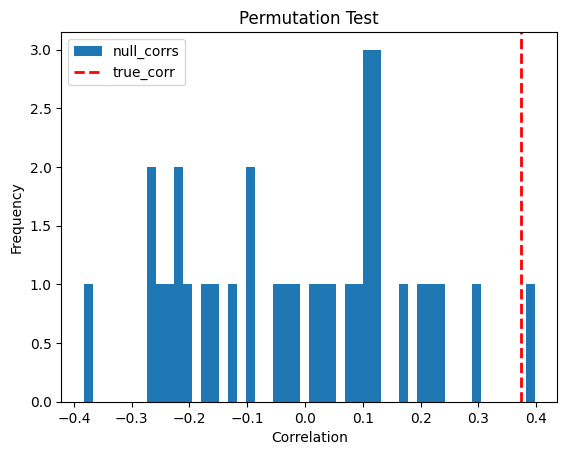

P-value: 0.088


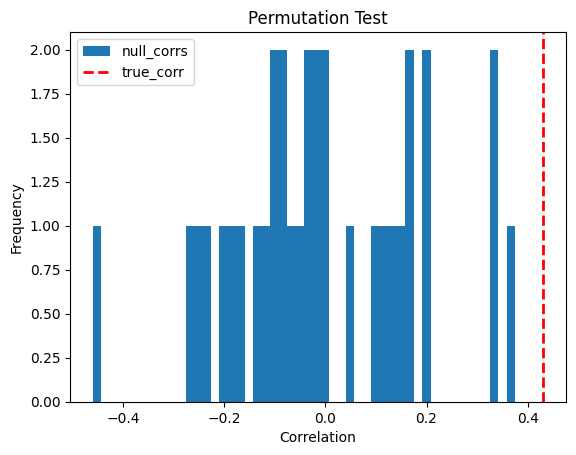

P-value: 0.059


In [ ]:
def permutation_test(C, R, logratios, n_permutations=100):

    n_permutations = min(n_permutations, len(logratios))

    true_corr = np.corrcoef(
        torch.norm(C - R, dim=-1, p=2), 
        logratios)[0, 1]
    
    null_corrs = []
    for _ in range(n_permutations):
        perm_logratios = logratios[torch.randperm(len(logratios))]
        null_corrs.append(np.corrcoef(torch.norm(C - R, dim=-1, p=2), perm_logratios)[0, 1])
    
    plt.hist(null_corrs, bins=50, label='null_corrs')
    plt.axvline(true_corr, color='r', linestyle='dashed', linewidth=2, label='true_corr')
    plt.title('Permutation Test')
    plt.xlabel('Correlation')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    p_value = (np.sum(np.abs(null_corrs) >= np.abs(true_corr)) + 1) / (n_permutations + 1)
    print(f"P-value: {p_value:.3f}")

print('is the red line outside the distribution of null correlations?')
permutation_test(C1, R1, logratios1)
permutation_test(C2, R2, logratios2)
# FAIL

### spearmanr kendalltau

In [ ]:
import numpy as np

In [ ]:
from scipy import stats


def correlation_dist(C, R, logratios):
    distances = torch.norm(C - R, dim=-1)
    logratios = logratios.cpu().numpy()
    corr, p = stats.spearmanr(distances, logratios)
    return np.abs(corr), p

print('spearmanr measure of dist ~ logratios should be large and significant')
corr, p = correlation_dist(C1, R1, logratios1)
n_corr, n_p = correlation_dist(C1, R1, logratios1.roll(1, 0))
shypothesis('corr>n_corr', variables=locals())
shypothesis('p<0.2', variables=locals())

def kendalltau_dist(C, R, logratios):
    distances = torch.norm(C - R, dim=-1)
    logratios = logratios.cpu().numpy()
    corr, p = stats.kendalltau(distances, logratios)
    return np.abs(corr), p

print('kendalltau measure of dist ~ logratios should be large and significant')
corr, p = kendalltau_dist(C1, R1, logratios1)
n_corr, n_p = kendalltau_dist(C1, R1, logratios1.roll(1, 0))
shypothesis('corr>n_corr', variables=locals())
shypothesis('p<0.2', variables=locals())
shypothesis('n_p>0.2', variables=locals())

spearmanr measure of dist ~ logratios should be large and significant
H		corr > n_corr
∴		0.333 > 0.008 ✅ [Δ = 0.325]

H		p < 0.2
∴		0.059 < 0.2 ✅ [Δ = -0.141]

kendalltau measure of dist ~ logratios should be large and significant
H		corr > n_corr
∴		0.246 > 0.034 ✅ [Δ = 0.212]

H		p < 0.2
∴		0.045 < 0.2 ✅ [Δ = -0.155]

H		nₚ > 0.2
∴		0.794 > 0.2 ✅ [Δ = 0.594]



In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

def angle_similarity_correlation(C, R, logratios):
    C_norm = F.normalize(C, p=2, dim=-1)
    R_norm = F.normalize(R, p=2, dim=-1)
    angle = torch.acos(torch.clamp(torch.sum(C_norm * R_norm, dim=-1), -1.0, 1.0))
    corrs = np.corrcoef(angle.cpu().numpy(), logratios.cpu().numpy())[0, 1]
    return (corrs)

def norm_difference_correlation(C, R, logratios):
    norm_diff = torch.norm(C, dim=-1) - torch.norm(R, dim=-1)
    corrs = np.corrcoef(norm_diff.cpu().numpy(), logratios.cpu().numpy())[0, 1]
    return (corrs)

def magnitude_correlation(C, R, logratios):
    magnitude_diff = torch.abs(C - R).mean(dim=-1)
    corrs = np.corrcoef(magnitude_diff.cpu().numpy(), logratios.cpu().numpy())[0, 1]
    return (corrs)

def inner_product_correlation(C, R, logratios):
    inner_prod = torch.sum(C * R, dim=-1)
    corrs = np.corrcoef(inner_prod.cpu().numpy(), logratios.cpu().numpy())[0, 1]
    return (corrs)

# Usage
def run_all_tests(C1, R1, C2, R2, logratios1, logratios2):
    tests = [
        angle_similarity_correlation,
        norm_difference_correlation,
        magnitude_correlation,
        inner_product_correlation
    ]
    
    for test in tests:
        print(f"\nTesting **{test.__name__}**:")
        c111 = test(C1, R1, logratios1) * 1e-12
        c222 = test(C2, R2, logratios2)
        c112 = test(C1, R1, logratios1.roll(1, 0))
        c221 = test(C2, R2, logratios2.roll(1, 0))
        
        print('Similarity of related ones should be higher')
        shypothesis('abs(c111) < abs(c112)', variables=locals(), verbose=1)
        shypothesis('abs(c222) < abs(c221)', variables=locals(), verbose=1)
        # Uncomment these if you want to test across different pairs
        # shypothesis('c111 > c221', variables=locals())
        # shypothesis('c222 > c112', variables=locals())

# Run all tests
run_all_tests(C1, R1, C2, R2, logratios1, logratios2)


Testing **angle_similarity_correlation**:
Similarity of related ones should be higher
H		│c₁₁₁│ < │c₁₁₂│
		│0.0│ < │-0.006│
∴		 0 < 0.006 ✅ [Δ = -0.006]

H		│c₂₂₂│ < │c₂₂₁│
		│0.238│ < │-0.277│
∴		 0.238 < 0.277 ✅ [Δ = -0.039]


Testing **norm_difference_correlation**:
Similarity of related ones should be higher
H		│c₁₁₁│ < │c₁₁₂│
		│0.0│ < │-0.273│
∴		 0 < 0.273 ✅ [Δ = -0.273]

H		│c₂₂₂│ < │c₂₂₁│
		│0.497│ < │-0.294│
∴		 0.497 < 0.294 ❌ [Δ = 0.203]


Testing **magnitude_correlation**:
Similarity of related ones should be higher
H		│c₁₁₁│ < │c₁₁₂│
		│0.0│ < │-0.035│
∴		 0 < 0.035 ✅ [Δ = -0.035]

H		│c₂₂₂│ < │c₂₂₁│
		│0.424│ < │-0.505│
∴		 0.424 < 0.505 ✅ [Δ = -0.081]


Testing **inner_product_correlation**:
Similarity of related ones should be higher
H		│c₁₁₁│ < │c₁₁₂│
		│0.0│ < │-0.031│
∴		 0 < 0.031 ✅ [Δ = -0.031]

H		│c₂₂₂│ < │c₂₂₁│
		│0.190│ < │0.015│
∴		 0.190 < 0.015 ❌ [Δ = 0.175]



### H: cosine_similarity_correlation

In [ ]:
def cosine_similarity_correlation(C, R, logratios):
    cos_sim = F.cosine_similarity(C, R, dim=-1)  # [batch, layers, tokens]

    corrs = np.corrcoef(cos_sim, logratios)[0, 1] 
    
    return np.abs(corrs)

c111 = cosine_similarity_correlation(C1, R1, logratios1)
c222 = cosine_similarity_correlation(C2, R2, logratios2)
c112 = cosine_similarity_correlation(C1, R1, logratios1.roll(1, 0))
c221 = cosine_similarity_correlation(C2, R2, logratios2.roll(1, 0))

print('cosine similarity of related ones should be higher')
shypothesis('c111 > c112', variables=locals(), verbose=True)
shypothesis('c222 > c221', variables=locals())
# shypothesis('c111 > c221', variables=locals())
# shypothesis('c222 > c112', variables=locals())

In [ ]:
def kl_divergence(p, q):
    return (p * (p / q).log()).sum(dim=-1)

def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

def mutual_information(C, R):
    joint = torch.einsum('bt,bt->bt', C, R)
    joint = joint / joint.sum(dim=-1, keepdim=True)
    mi = kl_divergence(joint, C * R)
    return mi

def info_theoretic_correlation(C, R, logratios):
    C_norm = F.softmax(C, dim=-1)
    R_norm = F.softmax(R, dim=-1)
    
    kl = kl_divergence(C_norm, R_norm)#.mean(dim=(1,))
    js = js_divergence(C_norm, R_norm)#.mean(dim=(1,))
    mi = mutual_information(C_norm, R_norm)#.mean(dim=(1,))
    
    kl_corr = np.abs(np.corrcoef(kl.cpu().numpy(), logratios)[0,1])
    js_corr = np.abs(np.corrcoef(js.cpu().numpy(), logratios)[0,1])
    mi_corr = np.abs(np.corrcoef(mi.cpu().numpy(), logratios)[0,1])
    
    return kl_corr, js_corr, mi_corr

print("C1-R1 with logratios1:")
kl1,js1,mi1 = info_theoretic_correlation(C1, R1, logratios1)
kl2,js2,mi2 = info_theoretic_correlation(C1, R1, logratios1.roll(1, 0))
shypothesis('kl1>kl2', variables=locals())
shypothesis('js1>js2', variables=locals())
shypothesis('mi1>mi2', variables=locals())

print("C2-R2 with logratios2:")
kl1,js1,mi1 = info_theoretic_correlation(C2, R2, logratios2)
kl2,js2,mi2 = info_theoretic_correlation(C2, R2, logratios2.roll(1, 0))
shypothesis('kl1>kl2', variables=locals())
shypothesis('js1>js2', variables=locals())
shypothesis('mi1>mi2', variables=locals())

In [ ]:
@torch.no_grad()
def rotation_test(C, R, logratios):
    def optimal_rotation(A, B):

        corr_matrix = torch.mm(A.t(), B)
        Q, _ = torch.linalg.qr(corr_matrix)
        return Q
    
    def optimal_rotation(A, B):
        corr_matrix = torch.mm(A.t(), B)
        U, _, V = torch.linalg.svd(corr_matrix)
        return torch.mm(U, V.t())
    
    R_opt = optimal_rotation(C, R)
    R_rotated = torch.matmul(R, R_opt.t())
    
    a = C - R
    b = C - R_rotated

    # a -= a.mean(dim=-1, keepdim=True)
    # b -= b.mean(dim=-1, keepdim=True)
    # a /= torch.norm(a, dim=0, p=2, keepdim=True)
    # b /= torch.norm(b, dim=0, p=2, keepdim=True)

    original_diff = torch.norm(a, p=2)
    rotated_diff = torch.norm(b, p=2)
    
    print(f"Original difference: {original_diff}")
    print(f"Rotated difference: {rotated_diff}")
    print(f"Improvement: {(original_diff - rotated_diff) / original_diff * 100:.2f}%")
    
    c = np.abs(np.corrcoef(torch.norm(a, dim=-1, p=2), logratios)[0, 1])
    r = np.abs(np.corrcoef(torch.norm(b, dim=-1, p=2), logratios)[0, 1])
    print(f"Correlation before rotation: {c:.2f}")
    print(f"Correlation after rotation: {r:.2f}")
    print(f"Improvement: {(r - c) / c * 100:.2f}%")
    print()
    shypothesis('r > c', variables=dict(r=r, c=c))
    return R_opt, R_rotated

# maybe I should softmax first?
R_opt, R_rotated = rotation_test(C1, R1, logratios1)
R_opt, R_rotated = rotation_test(C2, R2, logratios2)

R_opt, R_rotated = rotation_test(C2, R2, logratios2.roll(1, 0))
R_opt, R_rotated = rotation_test(C1, R1, logratios1.roll(1, 0))
# R_opt, R_rotated = rotation_test(C2, R2, logratios1)
# R_opt, R_rotated = rotation_test(C1, R1, logratios2)

### Principal Component Analysis (PCA):
Apply PCA to (A - B) pairs. If differences are primarily rotational, most variance should be explained by a few components.

In [ ]:
from sklearn.decomposition import PCA

def pca_exp_var(X, Y):
    diffs = (X - Y).numpy()
    s = diffs.std()
    diffs /= s
    # axis 1, norm each neuron across the batch
    # diffs /= diffs.std(1, keepdims=True) + 1e-3
    pca = PCA(n_components=5)
    pca.fit(diffs)
    r = pca.explained_variance_ratio_.mean()
    return r


# 
e_a1b1 = pca_exp_var(C1, R1)
e_a1b1roll = pca_exp_var(C1, R1.roll(1, 0))
shypothesis('e_a1b1 > e_a1b1roll', variables=locals())

e_a1b1 = pca_exp_var(C2, R2)
e_a1b1roll = pca_exp_var(C2, R2.roll(1, 0))
shypothesis('e_a1b1 > e_a1b1roll', variables=locals())

# e_a1a2 = pca_exp_var(C1, C2)
# e_a1b2 = pca_exp_var(C1, R2)
# e_b1b2 = pca_exp_var(R1, R2)
# e_b1a1 = pca_exp_var(R1, C1)
# e_b1a2 = pca_exp_var(R1, C2)

# print('PCA explained variance ratio')
# print('A1-B1', e_a1b2)
# shypothesis('e_a1b1 > e_a1a2', variables=locals())
# shypothesis('e_a1b1 > e_a1b2', variables=locals())
# shypothesis('e_a1b1 > e_b1b2', variables=locals()) # should be inconclusive
# e_a1b2, e_a1a2, e_a1b2, e_b1b2

## mutual_information

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def mutual_information(C, R, logratios):
    distances = torch.norm(C - R, dim=-1, p=2, keepdim=True)
    mi = mutual_info_regression(distances, logratios)[0]
    print(f"Mutual Information: {mi}")
    return mi

print('do the paired hs have information shared with the logratios?')
mi1 = mutual_information(C1, R1, logratios1)
mi2 = mutual_information(C1, R1, logratios1.roll(1, 0));
shypothesis('mi1 > mi2', variables=locals())

### Frobenius Norm Comparison:
Compare ||A - B||_F with ||A - RB||_F where R is the optimal rotation. The latter should be significantly smaller if rotations capture most differences.

In [ ]:
def norm_comparison(A, B):
    diff_norm = torch.norm(A - B)
    corr = torch.mm(A, B.t())
    U, _, V = torch.svd(corr)
    R = torch.mm(U, V.t())

    B_rot = torch.mm(R, B)

    rot_diff_norm = torch.norm(A - B_rot)
    return diff_norm, rot_diff_norm

print('passing means the paired samples can be rotated')
diff_norm, rot_diff_norm= norm_comparison(C1, R1)
shypothesis('rot_diff_norm < diff_norm', variables=locals())

print('passing means the paired samples can be rotated')
diff_norm, rot_diff_norm= norm_comparison(C2, R2)
# print(diff_norm, rot_diff_norm)
shypothesis('rot_diff_norm < diff_norm', variables=locals())

print('passing means the unrelated samples can be rotated')
diff_norm, rot_diff_norm= norm_comparison(C1, R2)
shypothesis('rot_diff_norm > diff_norm', variables=locals())

print('passing means the unrelated samples can be rotated')
diff_norm, rot_diff_norm= norm_comparison(C2, R1)
# print(diff_norm, rot_diff_norm)
shypothesis('rot_diff_norm > diff_norm', variables=locals())

# UNEEXPECTED result: C and R are already in a similar direction! While unrelated ones are not
# this implies that the preference concept that we want is not a factor of directions of the hidden states, but rather the magnitude of the difference between the two

In [ ]:
print('are the magnitudes related?')
def corr_mag(C, R, logratios):
    c_norm = torch.norm(C, dim=-1)
    r_norm = torch.norm(R, dim=-1)
    norm_diffs = r_norm - c_norm
    corr = (np.corrcoef(norm_diffs.flatten(), logratios)[0, 1])
    corr_null = (np.corrcoef(norm_diffs.flatten(), logratios.roll(1, 0))[0, 1])
    shypothesis('(corr) > (corr_null)', variables=locals(), verbose=True)


corr_mag(C1, R1, logratios1)
corr_mag(C2, R2, logratios2)

In [ ]:
diff_norm, rot_diff_norm= norm_comparison(C1, R2)
diff_norm, rot_diff_norm

Angle Histogram:
Plot histogram of angles between corresponding columns of A and B. Should be concentrated if differences are mainly rotational.

In [ ]:
def angle_histogram(A, B):
    cos_sims = torch.sum(A * B, dim=0) / (torch.norm(A, dim=0) * torch.norm(B, dim=0))
    angles = torch.acos(cos_sims) * 180 / np.pi
    plt.hist(angles.numpy())
    plt.show()

angle_histogram(C1, R1)

In [ ]:
def subspace_scaling(C, R, n_subspaces=10):
    pca = PCA(n_components=n_subspaces)
    pca.fit(np.vstack((C.reshape(-1, C.shape[-1]), R.reshape(-1, R.shape[-1]))))
    c_proj = pca.transform(C.reshape(-1, C.shape[-1]))
    r_proj = pca.transform(R.reshape(-1, R.shape[-1]))
    scale_ratios = np.linalg.norm(c_proj, axis=0) / np.linalg.norm(r_proj, axis=0)
    return scale_ratios

scales = subspace_scaling(C1, R1)
print("Subspace scaling ratios:", scales)

scales = subspace_scaling(C1, R2)
print("Subspace scaling ratios:", scales)

# ??
corr

In [ ]:
def sparsity_correlation(C, R, logratios):
    c_sparsity = (np.abs(C) > 1e-2).float().mean(dim=-1)
    r_sparsity = (np.abs(R) > 1e-2).float().mean(dim=-1)
    sparsity_diff = r_sparsity - c_sparsity
    corr = np.corrcoef(sparsity_diff.flatten(), logratios)[0, 1]
    print(f"Correlation of sparsity differences with logratios: {corr}")
    return (corr)

c111 = sparsity_correlation(C1, R1, logratios1)
c222 = sparsity_correlation(C2, R2, logratios2)

print('unrelated, should be null results')
c112 = sparsity_correlation(C1, R1, logratios1.roll(1, 0))
c221 = sparsity_correlation(C2, R2, logratios2.roll(1, 0))

shypothesis('c111 > c112', variables=locals())
shypothesis('c222 > c221', variables=locals())
shypothesis('c111 > c112', variables=locals())
shypothesis('c222 > c221', variables=locals())

# !!! SUCCESS

In [ ]:
from scipy.fft import fft

def fft_analysis(C, R):
    C_fft = fft(C.cpu().numpy(), axis=-1)
    R_fft = fft(R.cpu().numpy(), axis=-1)
    return C_fft - R_fft

def fft_corr(C, R, logratios):
    fft_diff = fft_analysis(C, R)
    fft_norm = np.linalg.norm(fft_diff, axis=-1)
    fft_corr = np.abs(np.corrcoef(fft_norm, logratios)[0,1])
    return fft_corr

c1 = fft_corr(C1, R1, logratios1)
c1n = fft_corr(C1, R1, logratios1.roll(1, 0))
shypothesis('c1 > c1n', variables=locals(), verbose=True)

c2 = fft_corr(C2, R2, logratios2)
c2n = fft_corr(C2, R2, logratios2.roll(1, 0))
shypothesis('c2 > c2n', variables=locals())

In [ ]:

def non_lin_corr(C, R, logratios):
    C = symlog(C)
    R = symlog(R)
    nl_diff = C - R
    nl_norm = torch.norm(nl_diff, dim=-1)
    nl_corr = np.corrcoef(nl_norm, logratios)[0,1]
    corr_null = np.corrcoef(nl_norm, logratios.roll(1,0))[0,1]
    shypothesis('abs(nl_corr) > abs(corr_null)', variables=locals(), verbose=True)

print('are the right pairs more correlate if we take the diff of the symlog?')
non_lin_corr(C1, R1, logratios1)
non_lin_corr(C2, R2, logratios2)
# but it's the same result without symlog...

In [ ]:
def relative_positioning(C, R, ref_point):
    C_rel = C - ref_point
    R_rel = R - ref_point
    return torch.norm(C_rel, dim=-1) - torch.norm(R_rel, dim=-1)

# Using mean of C2 as reference point
ref_point = C2.mean(dim=(0), keepdim=True)
rel_diff = relative_positioning(C1, R1, ref_point)
rel_corr = np.abs(np.corrcoef(rel_diff.flatten(), logratios1)[0,1])
rel_corr2 = np.abs(np.corrcoef(rel_diff.flatten(), logratios1.roll(1, 0))[0,1])
shypothesis('rel_corr > rel_corr2', variables=locals())

In [ ]:
def cosine_similarity(a, b):
    return F.cosine_similarity(a, b, dim=-1)

c1r1_sim = cosine_similarity(C1, R1)
c2r2_sim = cosine_similarity(C2, R2)

c1r1_sim_corr = np.corrcoef(c1r1_sim.flatten(), logratios1)[0,1]
c2r2_sim_corr = np.corrcoef(c2r2_sim.flatten(), logratios2)[0,1]
c1r1null_sim_corr = np.corrcoef(c1r1_sim.flatten(), logratios1.roll(1, 0))[0,1]
c2r2null_sim_corr = np.corrcoef(c2r2_sim.flatten(), logratios2.roll(1, 0))[0,1]
shypothesis('c1r1_sim_corr > c1r1null_sim_corr', variables=locals())
shypothesis('c2r2_sim_corr > c2r2null_sim_corr', variables=locals())

print(f"C1-R1 similarity correlation with logratio: {c1r1_sim_corr}")
print(f"C2-R2 similarity correlation with logratio: {c2r2_sim_corr}")

In [ ]:
def global_position(x, global_mean):
    return F.cosine_similarity(x - global_mean, global_mean, dim=-1)

global_mean = torch.cat([C1, R1, C2, R2], dim=0).mean(dim=(0), keepdim=True)

def glob_pos_corr(C, R, logratios):
    c_global = global_position(C, global_mean)
    r_global = global_position(R, global_mean)
    global_diff = c_global - r_global
    global_corr = np.corrcoef(global_diff.flatten(), logratios)[0,1]
    return np.abs(global_corr)

print('if we project hs onto the global mean then correlate...')
c1 = glob_pos_corr(C1, R1, logratios1)
c2 = glob_pos_corr(C2, R2, logratios2)
c3n = glob_pos_corr(C1, R1, logratios1.roll(1, 0))
c4n = glob_pos_corr(C2, R2, logratios2.roll(1, 0))
shypothesis('c1 > c3n', variables=locals())
shypothesis('c2 > c4n', variables=locals())

In [ ]:
def relative_position(a, b, ref):
    a_rel = F.cosine_similarity(a - ref, ref, dim=-1)
    b_rel = F.cosine_similarity(b - ref, ref, dim=-1)
    return a_rel - b_rel

# Use C2 mean as reference
def rel_pos_corr(C1, R1, C2, logratios1):
    ref = C2.mean(dim=(0), keepdim=True)
    rel_pos1 = relative_position(C1, R1, ref)
    rel_pos_corr = np.abs(np.corrcoef(rel_pos1.flatten(), logratios1)[0,1])
    return rel_pos_corr

c1 = rel_pos_corr(C1, R1, C2, logratios1)
c2 = rel_pos_corr(C2, R2, C1, logratios2)
c3n = rel_pos_corr(C1, R1, C2, logratios1.roll(1, 0))
c4n = rel_pos_corr(C2, R2, C1, logratios2.roll(1, 0))
shypothesis('c1 > c3n', variables=locals())
shypothesis('c2 > c4n', variables=locals())
print(f"Relative position correlation: {c1}")
print(f"Relative position correlation (null): {c2}")

In [ ]:
def projection_correlation(C, R, logratios):
    # Compute the mean difference vector
    mean_diff = (C - R).mean(dim=0)

    # Project samples onto this direction
    c_proj = F.cosine_similarity(C, mean_diff.unsqueeze(0), dim=-1)
    r_proj = F.cosine_similarity(R, mean_diff.unsqueeze(0), dim=-1)
    proj_diff = c_proj - r_proj

    proj_corr = np.abs(np.corrcoef(proj_diff, logratios)[0,1])
    return proj_corr

proj_corr1 = projection_correlation(C1, R1, logratios1)
print(f"Preference direction projection correlation: {proj_corr1}")

proj_corr2 = projection_correlation(C2, R2, logratios2)
print(f"Preference direction projection correlation: {proj_corr2}")

proj_corr3 = projection_correlation(C2, R2, logratios2.roll(1, 0))
print(f"Preference direction projection correlation: {proj_corr3}")


proj_corr4 = projection_correlation(C1, R1, logratios1.roll(1, 0))
print(f"Preference direction projection correlation: {proj_corr4}")

shypothesis('proj_corr1 > proj_corr4', variables=locals())
shypothesis('proj_corr2 > proj_corr3', variables=locals())


In [ ]:
def var_corr(C, R, logratios):
    c_var = C.var(dim=-1)
    r_var = R.var(dim=-1)
    var_diff = c_var - r_var

    var_corr = np.corrcoef(var_diff.flatten(), logratios)[0,1]
    return var_corr


vc0 = var_corr(C1, R1, logratios1)
print(f"Variance difference correlation: {vc0}")

vc1 = var_corr(C2, R2, logratios2)
print(f"Variance difference correlation: {vc1}")

vc2 = var_corr(C2, R2, logratios2.roll(1, 0))
print(f"Variance difference correlation: {vc2}")

vc3 = var_corr(C1, R1, logratios1.roll(1, 0))
print(f"Variance difference correlation: {vc3}")
shypothesis('abs(vc0) > abs(vc3)', variables=locals(), verbose=1)
shypothesis('abs(vc1) > abs(vc2)', variables=locals(), verbose=1)
